# Notebook to test and demo the reuseable functions in the codebase

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from importlib import reload
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.metrics import r2_score

In [2]:
from DRP_utils import data_preprocessing as dp_nb
reload(dp_nb)
from DRP_utils import model_selection as ms_nb
reload(ms_nb)

<module 'DRP_utils.model_selection' from '/Users/nik/Documents/OneDrive - Queen Mary, University of London/PhD_work/Year1/Codebase/Codebase/DRP_utils/model_selection.py'>

# Data reading and preprocessing

In [3]:
#read and format target values

df_ic50 = pd.read_csv('downloaded_data_small/GDSC1_ic50.csv')
frame = {}
for d in np.unique(df_ic50['CELL_LINE_NAME']):
    cellDf = df_ic50[df_ic50['CELL_LINE_NAME'] == d]
    cellDf.index = cellDf['DRUG_NAME']
    frame[d] = cellDf['LN_IC50']
    
    
def remove_repeats_mean_gdsc1(frame, df_ic50): 
    new_frame = {}
    for cell_line in np.unique(df_ic50['CELL_LINE_NAME']):
        temp_subset = frame[cell_line].groupby(frame[cell_line].index).mean()
        new_frame[cell_line] = temp_subset
    return new_frame  

new_frame = remove_repeats_mean_gdsc1(frame, df_ic50)
ic50_df1 = pd.DataFrame(new_frame).T

_all_drugs = ic50_df1.columns

In [4]:
#read and format phos data

phos_raw = pd.read_csv('downloaded_data_small/suppData2ppIndexPhospo.csv')
#makes index features 
phos_raw.index = phos_raw['col.name']
phos_raw.drop(columns='col.name', inplace=True)
#formats cell lines in the same way as in target value df. 
phos_raw.columns = [c.replace('.', '-') for c in phos_raw.columns]
phos_raw = phos_raw.T

In [5]:
phos_raw, ic50_df1 = dp_nb.keep_overlapping(phos_raw, ic50_df1)
_all_cells = phos_raw.index
phos_raw.shape, ic50_df1.shape

((42, 22804), (42, 345))

In [6]:
#log transfrom
phospho_log = np.log2(phos_raw).replace(-np.inf, 0)
#norm by cell line standard scale 
scale = StandardScaler()
phospho_ls = pd.DataFrame(scale.fit_transform(phospho_log.T),
                       columns = phospho_log.index,
                       index = phospho_log.columns).T
#drug one hot encoding
frame = {}
for i,d in enumerate(_all_drugs):
    hot_vec = np.zeros(len(_all_drugs))
    hot_vec[i] = 1
    frame[d] = hot_vec
one_hot_drugs = pd.DataFrame(frame)

In [7]:
x_all, x_drug, y_list = dp_nb.create_all_drugs(phospho_ls, one_hot_drugs, ic50_df1, _all_cells)
all_cls_drugs = x_all.index + '.' + x_drug.index 
x_all.shape, x_drug.shape, len(y_list)

((12903, 22804), (12903, 345), 12903)

In [8]:
#test train split
train_inds, test_inds = train_test_split(range(len(y_list)),test_size=0.8,
                                         random_state=42)
x_train, x_test = x_all.iloc[train_inds], x_all.iloc[test_inds]
y_train, y_test = y_list[train_inds], y_list[test_inds]
xdrug_train, xdrug_test = x_drug.iloc[train_inds], x_drug.iloc[test_inds]

In [9]:
print(x_train.shape, xdrug_train.shape, len(y_train))
x_test.shape, xdrug_test.shape, len(y_test)

(2580, 22804) (2580, 345) 2580


((10323, 22804), (10323, 345), 10323)

# Model bulding

In [10]:
def build_test_dnn(hps):
    num_uni, *_ = hps
    phos_input = layers.Input(shape=x_train.shape[1])
    x = layers.Dense(num_uni, activation='relu')(phos_input)
    drug_input = layers.Input(shape = (x_drug.shape[1]))
    concatenated = layers.concatenate([x, drug_input])
    hidd = layers.Dense(num_uni // 2, activation='relu')(concatenated)
    output_tensor = layers.Dense(1)(hidd)
    model = tf.keras.models.Model([phos_input,drug_input], output_tensor)
    model.compile(
        optimizer='rmsprop',
        loss=tf.keras.metrics.mean_squared_error,
        metrics=['mae'])
    return model

In [119]:
build_test_dnn([5]).summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 22804)]      0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 5)            114025      input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 345)]        0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 350)          0           dense_6[0][0]                    
                                                                 input_7[0][0]                

# Model seleciton

In [145]:
loss, val_loss, *_ = ms_nb.run_cv(build_test_dnn, 
                                  [x_train, x_drug],
                                  y_train,
                                  [5],
                                  batch_size=1,
                                  k=3)

0.0


2022-07-20 16:28:22.267025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-20 16:28:29.949209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.3333333333333333


2022-07-20 16:29:58.969226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-20 16:30:06.610385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.6666666666666666


2022-07-20 16:31:35.112716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-20 16:31:42.727711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(6.956934134165446, 0.266, 4)


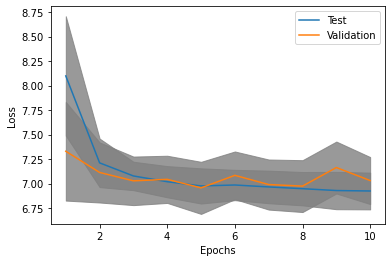

In [144]:
ms_nb.plot_cv(loss, val_loss, epochs=10)

# Testing

In [11]:
dnn_test = build_test_dnn([5])
dnn_test.fit([x_train, xdrug_train], y_train, epochs=5, batch_size=1)

Metal device set to: Apple M1 Pro


2022-07-21 14:30:13.506872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-21 14:30:13.507067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-21 14:30:14.091347: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-21 14:30:14.093747: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-21 14:30:14.233485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/5
2580/2580 [==============================] - 14s 6ms/step - loss: 7.0393 - mae: 2.0878
Epoch 2/5
2580/2580 [==============================] - 14s 6ms/step - loss: 6.7872 - mae: 2.0509
Epoch 3/5
2580/2580 [==============================] - 15s 6ms/step - loss: 6.7784 - mae: 2.0451
Epoch 4/5
2580/2580 [==============================] - 14s 6ms/step - loss: 6.6767 - mae: 2.0351
Epoch 5/5
2580/2580 [==============================] - 15s 6ms/step - loss: 6.6502 - mae: 2.0297


-9.7939622449161

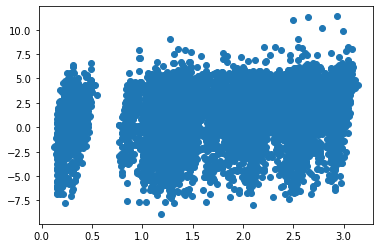

In [73]:
dnn_pre = dnn_test.predict([x_test, xdrug_test])
dnn_pre = dnn_pre.reshape(len(dnn_pre))
plt.scatter(dnn_pre, y_test)
r2_score(dnn_pre, y_test)

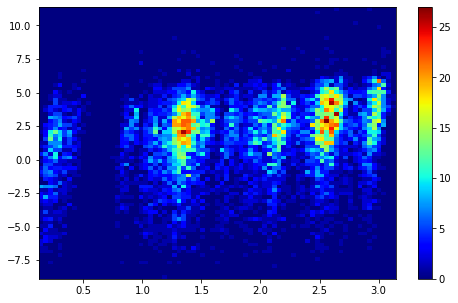

-9.7939622449161

In [74]:
fig, ax = plt.subplots(figsize=(8, 5))
pcm = ax.hist2d(dnn_pre.reshape(len(dnn_pre)), y_test, bins=75, cmap=plt.cm.jet)
fig.colorbar(pcm[3])
plt.show()
r2_score(dnn_pre, y_test)

In [68]:
all_cls_drugs

Index(['CMK.(5Z)-7-Oxozeaenol', 'COLO-680N.(5Z)-7-Oxozeaenol',
       'GDM-1.(5Z)-7-Oxozeaenol', 'HEL.(5Z)-7-Oxozeaenol',
       'HL-60.(5Z)-7-Oxozeaenol', 'JHH-2.(5Z)-7-Oxozeaenol',
       'JHH-4.(5Z)-7-Oxozeaenol', 'KASUMI-1.(5Z)-7-Oxozeaenol',
       'KG-1.(5Z)-7-Oxozeaenol', 'KMOE-2.(5Z)-7-Oxozeaenol',
       ...
       'P31-FUJ.rTRAIL', 'PL-21.rTRAIL', 'SK-HEP-1.rTRAIL', 'SKM-1.rTRAIL',
       'SNU-182.rTRAIL', 'SNU-387.rTRAIL', 'SNU-398.rTRAIL', 'SNU-423.rTRAIL',
       'SNU-449.rTRAIL', 'THP-1.rTRAIL'],
      dtype='object', length=12903)

In [76]:
def sort_results(pre, true, cls_drug_inds, centered):
    '''Sorts results so that they are drug and cell lines centered.
    
    Allows the resuts to viwed in terms of cell lines or drugs.
    I.e. The peformance of the model for a given cell line or drug 
    in the test set
    
    Inputs
    ------
    pre: array or list or pd index
    models predicted results
    
    true: array or list or pd index
    target values
    
    cls_drug_inds: array or list or pd index
    gives the cell line and drug for the true and pre values.
    Indices need to match pre and true. I.e. cls_drug_inds[0] need to give
    the cell line and drug that corrisonds with true[0] and pre[0] (When 
    inputs are lists)
    Entires need to be in the format 'cellLine.drug'
    
    centered: Int, 0 or 1
    if the sorted results should be drug or cell line centered.
    0 the sorted results are cell line centered
    1 the sorted results are drug centered 
    
    Retruns
    -------
    sorted_results: dict
    keys either drugs or cell lines. Items tuple of predicted , true values 
    where predcited and true are lists. 
    '''
    #check same shape 
    assert pre.shape == true.shape
    
    sorted_results = {}
    
    for pre, true, cl_drug in zip(pre, true, cls_drug_inds):
        cl, drug = cl_drug.split('.')
        if centered == 0:
            key = cl
        if centered == 1:
            key = drug
        if key not in sorted_results.keys():
            sorted_results[key] = ([pre], [true])
        else:
            sorted_results[key][0].append(pre)
            sorted_results[key][1].append(true)
            
    return sorted_results

In [78]:
cl_results = sort_results(dnn_pre, y_test, all_cls_drugs[test_inds], centered=0)
drug_results = sort_results(dnn_pre, y_test, all_cls_drugs[test_inds], centered=1)

In [80]:
drug_results

{'KIN001-260': ([2.6879802,
   1.4272007,
   2.5981739,
   2.171375,
   1.5477415,
   0.280266,
   1.3246257,
   2.6642673,
   0.93436515,
   2.1854997,
   1.370417,
   1.4449393,
   2.9905338,
   2.516328,
   1.9507209,
   3.0115306,
   2.1928248,
   1.8096142,
   1.3871593,
   2.7006466,
   0.28035668,
   1.3549049,
   1.5971513,
   3.0058782,
   2.233445,
   1.1089696,
   1.4481628,
   2.83679,
   2.5504973],
  [5.628626,
   2.22231,
   5.052319,
   5.722223,
   2.078027,
   2.134372,
   3.519112,
   4.614852,
   2.909456,
   1.590922,
   2.686941,
   2.77139,
   6.032549,
   4.157951,
   3.125406,
   5.954821,
   4.02636,
   4.55994,
   2.683255,
   4.516801,
   0.909664,
   2.998305,
   3.440411,
   5.039163,
   3.836673,
   2.406275,
   2.432901,
   5.005738,
   5.535444]),
 'ZM447439': ([2.6066518,
   0.18343684,
   2.5702724,
   1.276422,
   1.4537464,
   1.1825975,
   2.335727,
   0.8403702,
   0.18190198,
   2.9512858,
   2.7427952,
   1.0149746,
   2.1912467,
   1.3509442,
 

In [ ]:
# drug and cell line centered resutls 

drug_r = {}
cl_r = {}
for pre, true, cl_drug in zip(cnn1_pre, y_test, all_cls_drugs[test_inds]):
    cl, drug = cl_drug.split('.')
    if cl not in cl_r.keys():
        cl_r[cl] = ([pre[0]], [true])
    else:
        cl_r[cl][0].append(pre[0])
        cl_r[cl][1].append(true)
    if drug not in drug_r.keys():
        drug_r[drug] = ([pre[0]], [true])
    else:
        drug_r[drug][0].append(pre[0]) 
        drug_r[drug][1].append(true) 
                               